In [1]:
from transformers import SamModel, SamConfig, SamProcessor
import torch, importlib
import cv2, random, os

import format_images

importlib.reload(format_images)
from format_images import format_depth

/home/am0532/.conda/envs/tumor-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_bounding_box(image_mask):
    
    if np.all(image_mask == 0):
        # If all zeros, create a random bounding box
        H, W = image_mask.shape
        x_min = np.random.randint(0, W)
        x_max = np.random.randint(x_min + 1, W + 1)  # Ensure x_max > x_min
        y_min = np.random.randint(0, H)
        y_max = np.random.randint(y_min + 1, H + 1)  # Ensure y_max > y_min
        
        bbox = [x_min, y_min, x_max, y_max]
    else: 
        if len(image_mask.shape) == 2 or image_mask.shape[2] == 1:
            gray = image_mask
        else:
            gray = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)

        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return (0, 0, 0, 0)
        
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        bbox = [x, y, x+w, y+h]
    
    return bbox

In [3]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("./models/SAM1.pth"))

# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [4]:
train_images, train_masks, val_images, val_masks, test_images, test_masks = format_depth()

In [11]:
# let's take a random training example
idx = random.randint(0, len(train_images) -1)
print(idx)

15


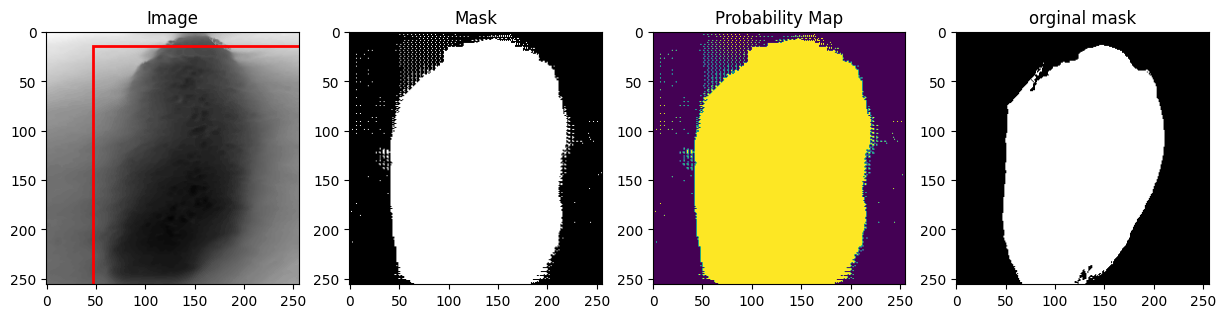

In [12]:

import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle



# load image
test_image = train_images[idx]

# get box prompt based on ground truth segmentation map
ground_truth_mask = train_masks[idx]

# test bounding box 
#bbox = [0,0,256,256]

pointer_prompt = [100,150]

prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

bbox = prompt  # Assuming prompt is the bounding box coordinates
rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the original mask
axes[3].imshow(train_masks[idx], cmap = "gray")
axes[3].set_title("orginal mask")


# Display the images side by side
plt.show()